In [51]:
from trading_ig import IGService
from autoIG.config import ig_service_config,open_position_config_,close_position_config_
ig_service = IGService(**ig_service_config)
from autoIG.instruments import Epics
from datetime import date
import pandas as pd
from autoIG.utils import TMP_DIR
create_session_responce = ig_service.create_session()

In [53]:
def mins_to_ms(m = 1):
    return 1000*60*m

In [54]:
transactions = ig_service.fetch_transaction_history_by_type_and_period(trans_type='ALL',milliseconds=mins_to_ms(10))
activity = ig_service.fetch_account_activity(
    from_date=date(2022,12,28),
    to_date=date(2023,1,1),
    detailed=True,
    )

In [82]:
activity_filtered = activity[activity.direction=='SELL'][['date','epic','dealId','affectedDealId']]
activity_filtered = activity_filtered.rename(columns = {'dealId':'closing_dealId','affectedDealId':'opening_dealId','date':'sell_date'})

In [83]:
activity_filtered

,sell_date,epic,closing_dealId,opening_dealId
0,2022-12-30T08:35:01,CC.D.CL.USS.IP,DIAAAALG2A5UNAT,DIAAAALG2AFVMBD
2,2022-12-30T08:34:03,CC.D.CL.USS.IP,DIAAAALG2AXABAX,DIAAAALGZ9V26AP
4,2022-12-30T08:33:03,CC.D.CL.USS.IP,DIAAAALG2AE4EAK,DIAAAALGZ9475AQ
6,2022-12-30T08:32:01,CC.D.CL.USS.IP,DIAAAALGZ9V5GAP,DIAAAALG2ADNAAM
21,2022-12-29T21:04:00,CS.D.GBPUSD.TODAY.IP,DIAAAALGUUXSKA3,DIAAAALGUT7GQAH
23,2022-12-29T21:03:00,CS.D.GBPUSD.TODAY.IP,DIAAAALGUUZ4HA5,DIAAAALGUVCLQAT
30,2022-12-28T22:13:23,CS.D.GBPUSD.TODAY.IP,DIAAAALGKBT6QBA,DIAAAALGKAQMLBB


In [84]:
transactions_filtered = transactions.drop(['date','period','transactionType','cashTransaction'],axis=1)
transactions_filtered=  transactions_filtered.rename(columns = {'reference':'closing_dealId'}).astype({'openLevel':float,'closeLevel':float})

In [85]:
position_metrics=  pd.read_csv(TMP_DIR/'position_metrics.csv')
position_metrics = position_metrics.rename(columns = {'dealId':'opening_dealId'})

In [94]:
joined = transactions_filtered.merge(activity_filtered, left_on='closing_dealId',right_on='closing_dealId').merge(position_metrics,left_on='opening_dealId',right_on='opening_dealId')
joined['actual'] = joined['closeLevel']/ joined['openLevel']
joined['profitAndLoss_numeric'] = joined['profitAndLoss'].str.removeprefix('£').astype(float)

In [95]:
reorder = [
    "sell_date",
    "buy_date",
    "epic",
    "opening_dealId",
    "closing_dealId",
    "openLevel",
    "closeLevel",
    "instrumentName",
    "profitAndLoss",
    'profitAndLoss_numeric',
    "size",
    "currency",
    "dealreference",
    "model_used",
    "prediction",
    'actual'
]

In [99]:
print(joined.shape)
print(joined[reorder].shape)
joined[reorder].sort_values('sell_date',ascending=True)


(4, 16)
(4, 16)


,sell_date,buy_date,epic,opening_dealId,closing_dealId,openLevel,closeLevel,instrumentName,profitAndLoss,profitAndLoss_numeric,size,currency,dealreference,model_used,prediction,actual
3,2022-12-30T08:32:01,2022-12-30 08:29:00.351,CC.D.CL.USS.IP,DIAAAALG2ADNAAM,DIAAAALGZ9V5GAP,7872.6,7871.3,Oil - US Crude,£-1.30,-1.3,+1,£,P39FRZKS2SNTYQR,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000177,0.999835
2,2022-12-30T08:33:03,2022-12-30 08:30:00.296,CC.D.CL.USS.IP,DIAAAALGZ9475AQ,DIAAAALG2AE4EAK,7882.6,7874.1,Oil - US Crude,£-8.50,-8.5,+1,£,8W8TZ5MXRWNTYQR,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000490,0.998922
1,2022-12-30T08:34:03,2022-12-30 08:31:01.969,CC.D.CL.USS.IP,DIAAAALGZ9V26AP,DIAAAALG2AXABAX,7876.6,7871.8,Oil - US Crude,£-4.80,-4.8,+1,£,JMC34U69JT2TYQR,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000311,0.999391
0,2022-12-30T08:35:01,2022-12-30 08:32:01.393,CC.D.CL.USS.IP,DIAAAALG2AFVMBD,DIAAAALG2A5UNAT,7875.1,7878.3,Oil - US Crude,£3.20,3.2,+1,£,GJU29XBDV6WTYQR,/Users/ezracitron/my_projects/auto_IG/mlruns/9...,1.000005,1.000406


In [104]:
for i,df in joined.groupby('opening_dealId'):
    print(df)

   instrumentName profitAndLoss   closing_dealId  openLevel  closeLevel size  \
3  Oil - US Crude        £-1.30  DIAAAALGZ9V5GAP     7872.6      7871.3   +1   

  currency            sell_date            epic   opening_dealId  \
3        £  2022-12-30T08:32:01  CC.D.CL.USS.IP  DIAAAALG2ADNAAM   

     dealreference  prediction  \
3  P39FRZKS2SNTYQR    1.000177   

                                          model_used                 buy_date  \
3  /Users/ezracitron/my_projects/auto_IG/mlruns/9...  2022-12-30 08:29:00.351   

     actual  profitAndLoss_numeric  
3  0.999835                   -1.3  
   instrumentName profitAndLoss   closing_dealId  openLevel  closeLevel size  \
0  Oil - US Crude         £3.20  DIAAAALG2A5UNAT     7875.1      7878.3   +1   

  currency            sell_date            epic   opening_dealId  \
0        £  2022-12-30T08:35:01  CC.D.CL.USS.IP  DIAAAALG2AFVMBD   

     dealreference  prediction  \
0  GJU29XBDV6WTYQR    1.000005   

                             

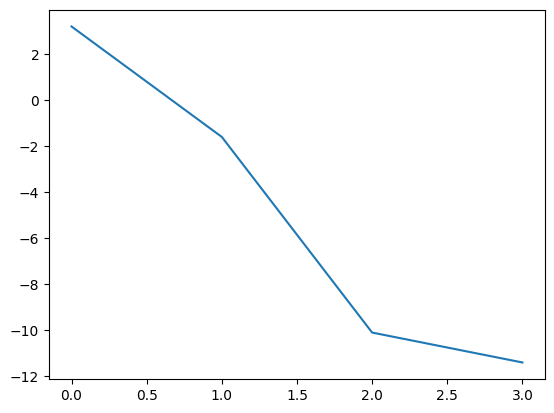

In [105]:
# Profit over time for a each model
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
# ax.plot(joined.profitAndLoss_numeric)
for v,df in joined.groupby('model_used'):
    ax.plot(df.profitAndLoss_numeric.cumsum())
